In [8]:
import sys

# need to add cocpit dir to path - can't relative import with sister directory
sys.path.insert(0, "..")

import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.utils.data.sampler as samp

import cocpit.config as config
import cocpit.data_loaders as data_loaders
import cocpit.plotting_scripts.plot_metrics as plot_metrics
import cocpit.predictions as predictions

sns.set_style("whitegrid")
import torch
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
plt_params = {
    "axes.labelsize": "xx-large",
    "axes.titlesize": "xx-large",
    "xtick.labelsize": "xx-large",
    "ytick.labelsize": "xx-large",
    "legend.title_fontsize": 12,
}
plt.rcParams["font.family"] = "serif"
plt.rcParams.update(plt_params)

# confusion matrices from folds

In [9]:
"""
iterate through each fold and append predictions and actual labels
changing saved model and validation data each time
"""
kfolds = 1  # CHANGE BACK TO 5
all_preds = []
all_labels = []
for fold in range(kfolds):
    val_data = torch.load(
        f"{config.VAL_LOADER_SAVE_DIR}e{config.MAX_EPOCHS}"
        f"_val_loader20_bs{config.BATCH_SIZE}"
        f"_k{str(fold)}_vgg16.pt"
    )

    model_name = (
        f"{config.MODEL_SAVE_DIR}e{config.MAX_EPOCHS}"
        f"_bs{config.BATCH_SIZE}"
        f"_k{str(fold)}_vgg16.pt"
    )

    model = torch.load(model_name)    
    val_sampler = samp.RandomSampler(val_data)
    val_loader = data_loaders.create_loader(
                val_data, batch_size=100, sampler=val_sampler
                )
    # get predictions from val loader
    for ((imgs, labels, img_paths), index) in val_loader:
        b = predictions.BatchPredictions(imgs, img_paths, model, labels)
        b.find_max_preds()
        all_preds.append(b.max_preds)
        all_labels.append(labels)
all_preds = np.asarray(list(itertools.chain(*all_preds)))
all_labels = np.asarray(list(itertools.chain(*all_labels)))

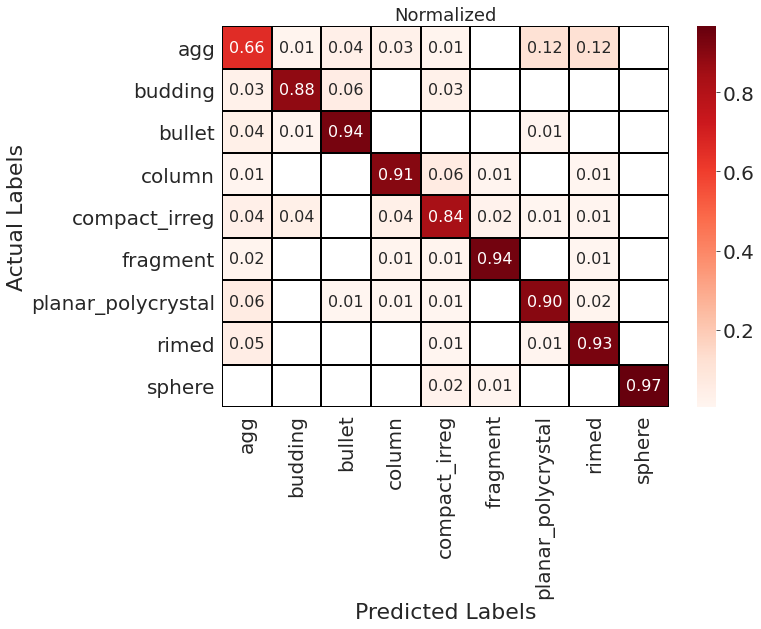

In [11]:
# plot/save conf matrix
save_name = "/data/data/plots/conf_matrix_allfolds.pdf"

plot_metrics.conf_matrix(
    all_labels, all_preds, norm="true", save_name=save_name, save_fig=True
)

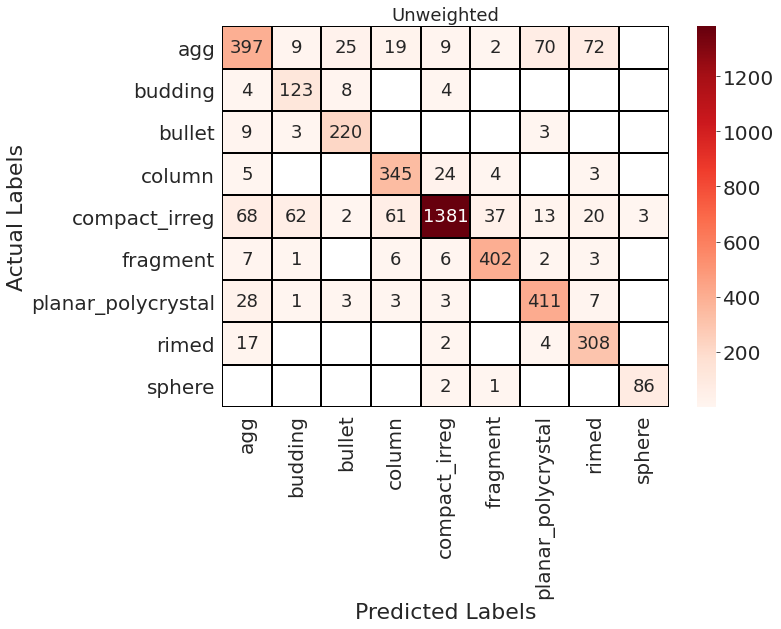

In [12]:
# plot/save conf matrix
save_name = "/data/data/plots/conf_matrix_allfolds.pdf"

plot_metrics.conf_matrix(
    all_labels, all_preds, norm=None, save_name=save_name, save_fig=True
)

### plot confusion matrix on one validation dataloader (no folds)

In [14]:
"""
iterate through each fold and append predictions and actual labels
changing saved model and validation data each time
"""

val_data = torch.load(
    "/data/data/saved_val_loaders/no_mask/v1.4.0/e[15]_val_loader20_bs[64]_k0_vgg16.pt"
)
model = torch.load(
    "/data/data/saved_models/no_mask/v1.4.0/e[15]_bs[28]_k0_vgg16.pt"
).cuda()
bs_idx = config.MODEL_SAVENAME.find("bs")
batch_size = int(config.MODEL_SAVENAME[bs_idx + 2 : bs_idx + 4])


val_loader = data_loaders.create_loader(val_data, batch_size, sampler=None)
all_preds = []
all_labels = []
for ((imgs, labels, img_paths), index) in val_loader:
        b = predictions.BatchPredictions(imgs, img_paths, model, labels)
        b.find_max_preds()
        all_preds.append(b.max_preds)
        all_labels.append(labels)
all_preds = np.asarray(list(itertools.chain(*all_preds)))
all_labels = np.asarray(list(itertools.chain(*all_labels)))

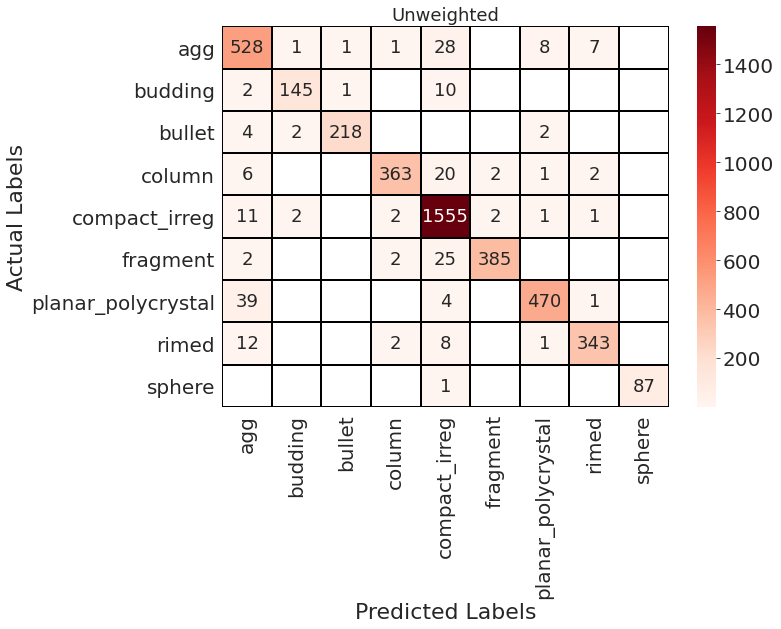

In [15]:
# plot/save conf matrix from one val_loader
# don't normalize (show magnitude of predictions per class)
save_name = "/data/data/plots/conf_matrix_v1.4.0.pdf"

plot_metrics.conf_matrix(all_preds, all_labels, norm=None, save_name=save_name)

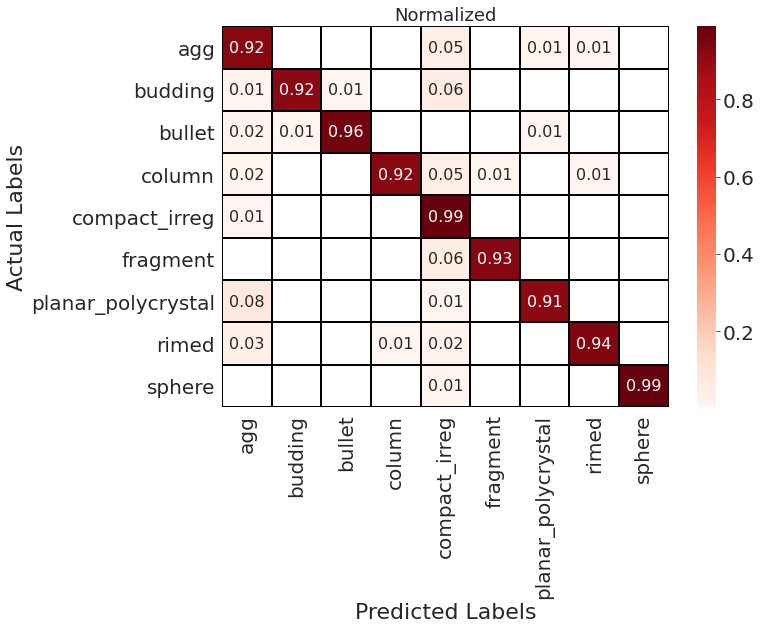

In [16]:
# plot/save conf matrix from one val_loader
# normalize (show relative % of (in)correct predictions)
save_name = "/data/data/plots/norm_conf_matrix_v1.4.0.pdf"

plot_metrics.conf_matrix(all_preds, all_labels, norm="true", save_name=save_name)